In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
mnist = datasets.MNIST('./mnist_data', train=True, download=False)

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_data = TensorDataset(mnist.train_data.reshape(-1,28*28).float()/255, mnist.train_labels)
validation_data = TensorDataset(mnist.test_data.reshape(-1,28*28).float()/255, mnist.test_labels)
train_dl = DataLoader(train_data, batch_size=32)
validation_dl = DataLoader(validation_data, batch_size=32)

/Users/Kohmis/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/Kohmis/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/Kohmis/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/Kohmis/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


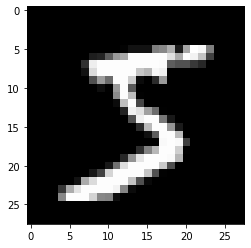

In [219]:
plt.imshow(mnist.test_data[0], cmap='gray')

In [236]:
train_dl.

TypeError: 'DataLoader' object does not support indexing

In [256]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class simple_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28*28, 10)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        return x

class simple_CONVnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1) # 28x28 -> ((28-3) + 2*1) / 2 = 14
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1) # 14x14 -> ((14-3) + 2*1) / 2 = 7
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # 7x7 -> ((7-3) + 2*1) / 2 = 3

    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # reshapes it to be 1 channel, 28x28
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4) # 4x4 pooling
        return x.view(-1, x.size(1))

In [17]:
def get_model():
    model = simple_CONVnet()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    return model, optimizer

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [18]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    pred = model(xb)
    loss = loss_fn(pred, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [57]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() # used by dropout and batchnorm
        losses = 0
        for xb, yb in train_dl:
            loss, _ = loss_batch(model, loss_fn, xb, yb, opt)
            losses += loss

        print(f'epoch {epoch+1}/{epochs} loss {losses/len(train_dl)}', end="")
        model.eval()
        with torch.no_grad():
            valid_loss = sum(loss_fn(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        print(f", {valid_loss}, {sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)}")

In [260]:
model, opt = get_model()
fit(5, model, F.cross_entropy, opt, train_dl, validation_dl)

epoch 1/5 loss 1.4808483223756155, 0.8747973442077637, 0.7307500243186951
epoch 2/5 loss 0.6424108050386111, 0.670296311378479, 0.7911666631698608
epoch 3/5 loss 0.49080404533545174, 0.4596674144268036, 0.8563833236694336
epoch 4/5 loss 0.3957116898437341, 0.44130179286003113, 0.863016664981842
epoch 5/5 loss 0.33897911948362985, 0.3579135239124298, 0.8917333483695984


In [289]:
for x,y in train_dl:
    print(x.shape, y.shape)
    test_batch = x
    break

torch.Size([32, 784]) torch.Size([32])


In [291]:
train_dl.dataset[0][0].view(28,28)
test_batch.size()

torch.Size([32, 784])

In [285]:
conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2)

In [292]:
x = conv1(test_batch.view(-1, 1,28,28))
x.size()

torch.Size([32, 16, 13, 13])

In [295]:
x.view(x.size(0), -1).size()

torch.Size([32, 2704])

# VAE

In [178]:
import torch
from torch.utils.data import TensorDataset
from torch import optim
from VAE import VAE, loss_fun
from utils import *
from torchvision import datasets
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
%autoreload
mnist = datasets.MNIST('./mnist_data', train=True, download=False)

train_data = TensorDataset(mnist.train_data.float()/255, mnist.train_data.float()/255)
validation_data = TensorDataset(mnist.test_data.float()/255, mnist.test_data.float()/255)
train_dl, validation_dl = get_data(train_data, validation_data, 32)

In [183]:
%autoreload
model = VAE(latent_size=4)
opt = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = loss_fun

In [184]:
def fit_VAE(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() # used by dropout and batchnorm

        for xb, yb in train_dl:
            pred, mean, logvar = model(xb)
            loss = loss_fn(yb, pred, mean, logvar)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            for xb, yb in valid_dl:
                pred, mean, logvar = model(xb)
                valid_loss += loss_fn(yb, pred, mean, logvar)

        print(f"Epoch: {epoch+1}/{epochs}, {valid_loss / len(valid_dl)}")

In [ ]:
%autoreload
fit_VAE(15, model, loss_fn, opt, train_dl, validation_dl)

Epoch: 0/15, 23489.57421875
Epoch: 1/15, 16269.5126953125
Epoch: 2/15, 13943.5673828125
Epoch: 3/15, 13449.837890625


torch.Size([1, 28, 28])


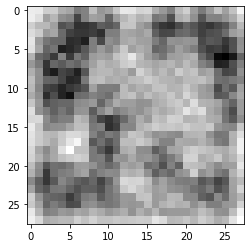

torch.Size([1, 28, 28])


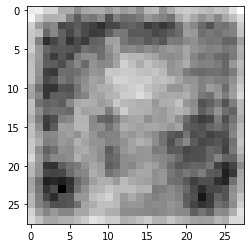

torch.Size([1, 28, 28])


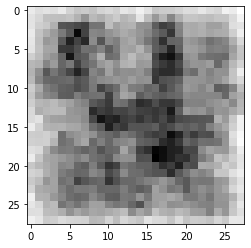

torch.Size([1, 28, 28])


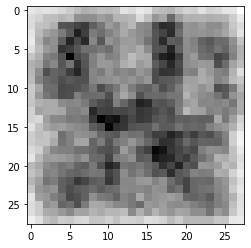

In [177]:
%autoreload
import matplotlib.pyplot as plt
with torch.no_grad():
    for _ in range(4):
        z = torch.randn(1, 4)
        pred = model.decode(z)
        print(pred.size())
        plt.imshow(pred[0], cmap='gray')
        plt.show()